# Wavenumber Grid Stitching, and Open and Closed Cross Sections  

2025/2/20 Hajime Kawahara

In [1]:

from jax import config

config.update("jax_enable_x64", True)


`OpaPremodit` divides the wavenumber range into `nstitch` segments, calculates the cross-section for each segment, and sums them up (*$\nu$-stitching*). Here, we manually demonstrate how *$\nu$-stitching* is performed.

Here, we consider the wavenumber-direction stitching of the cross section. We define a wavenumber grid of length \(2N\) before stitching, as well as two wavenumber grids of length \(N\) each, obtained by splitting the original grid. Can the cross sections be computed separately on these subdivided wavenumber grids and then combined?

In [2]:
from exojax.utils.grids import wavenumber_grid
from exojax.test.emulate_mdb import mock_mdb

mdb = mock_mdb("exomol")
filter_length_oneside = 10000
nu_grid, _, res = wavenumber_grid(4325.0, 4365.0, 2*filter_length_oneside, xsmode="premodit")

nu_grid_left = nu_grid[0:filter_length_oneside]
nu_grid_right = nu_grid[filter_length_oneside:]

/home/kawahara/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


xsmode =  modit
xsmode assumes ESLOG in wavenumber space: xsmode=modit
Your wavelength grid is in ***  ascending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
HITRAN exact name= (12C)(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


Molecule:  CO
Isotopologue:  12C-16O
ExoMol database:  None
Local folder:  CO/12C-16O/SAMPLE
Transition files: 
	 => File 12C-16O__SAMPLE.trans
Broadener:  H2
Broadening code level: a0
DataFrame (self.df) available.
xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.16-py3.10.egg/radis/api/exomolapi.py:687: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


We will calculate the cross sections for each of these three types of wavenumber grids using PreMODIT (`nustitch=1` by default).

In [3]:
from exojax.opacity.opacalc import OpaPremodit

T=1000.0 #K
P=1.0 #bar

opa_close_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
)
xsv_close_right = opa_close_right.xsvector(T,P)

opa_close_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
)
xsv_close_left = opa_close_left.xsvector(T,P)


opa_close_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
)
xsv_close_all= opa_close_all.xsvector(T,P)



/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K


/home/kawahara/exojax/src/exojax/spec/initspec.py:299: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn("Some of the line centers are outside of the wavenumber grid.")
/home/kawahara/exojax/src/exojax/spec/initspec.py:300: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]

Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%


cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [19.95496988332434, 20.139524518083817] cm-1


/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:299: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn("Some of the line centers are outside of the wavenumber grid.")
/home/kawahara/exojax/src/exojax/spec/initspec.py:300: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 4739.33it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%


/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [19.86332317448523, 20.047030209625518] cm-1
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]

Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%


cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [39.63542054375557, 40.37197010095406] cm-1


The cross sections computed after wavenumber splitting do not fully match those computed without splitting, particularly around the splitting points and near the endpoints. This discrepancy arises from the following reasons.  

In the default cross-section calculation of PreMODIT and MODIT, the Voigt profile convolution is performed using FFT. To eliminate aliasing effects, a buffer region of the same size as the computational domain is allocated, storing aliasing contributions from both sides. Since this buffer region is unnecessary for an individual wavenumber grid, it does not appear in the output. This calculation mode is referred to as the "closed aliasing mode."  

However, profile leakage from outside the wavenumber grid cannot be accounted for. As a result, around the splitting points, mutual leakage between the left and right wavenumber grids is ignored, leading to discrepancies in the computed cross sections at these points. Additionally, the mismatch near the endpoints occurs because the default assumption is that the Voigt profile's influence extends over a region equal to the size of one side of the wavenumber grid. Consequently, when the lengths of the wavenumber grids differ, slight discrepancies arise in the tail regions of the computed cross sections.

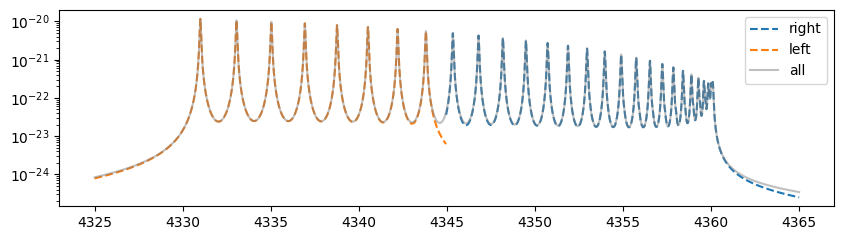

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 2.55))
plt.plot(nu_grid_right, xsv_close_right, ls="--", label="right")
plt.plot(nu_grid_left, xsv_close_left, ls="--", label="left")
plt.plot(nu_grid, xsv_close_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

The solution is to compute the aliasing region beyond the boundaries of the wavenumber domain and then sum the overlapping regions from different wavenumber domains afterward. This approach corresponds to the overlap-and-add (OLA) method.  

To achieve this, the convolution must be computed in an open manner by including buffer regions on both sides of the wavenumber domain. PreMODIT (with `nstitch`>1)supports this approach through the open aliasing. Additionally, the extent of the Voigt profile beyond one side of the wavenumber domain can be specified using the `cutwing` parameter.

Here, we manually calculate the open-mode cross-section from `opa` to reproduce the algorithm in `OpaPremodit`. This can be done using `spec.premodit.xsvector_open_zeroth`.

In [5]:
from exojax.opacity.premodit import xsvector_open_zeroth
from exojax.database.hitran import normalized_doppler_sigma

def xsv_open(opa,T,P):
    opa.alias = "open"
    opa.set_aliasing()
    (
            multi_index_uniqgrid,
            elower_grid,
            ngamma_ref_grid,
            n_Texp_grid,
            R,
            pmarray,
        ) = opa.opainfo
    nsigmaD = normalized_doppler_sigma(T, mdb.molmass, res)
    qt = opa.mdb.qr_interp(T, opa.Tref)
    
    xsv_open_right = xsvector_open_zeroth(
                T,
                P,
                nsigmaD,
                opa.lbd_coeff,
                opa.Tref,
                R,
                opa.nu_grid,
                elower_grid,
                multi_index_uniqgrid,
                ngamma_ref_grid,
                n_Texp_grid,
                qt,
                opa.Tref_broadening,
                opa.nu_grid_extended,
                opa.filter_length_oneside,
                opa.Twt,
            )

    return xsv_open_right


In [6]:

opa_open_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    cutwing=1.0,
)

xsv_open_right = xsv_open(opa_open_right, T, P)

opa_open_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    cutwing=1.0,
)
xsv_open_left = xsv_open(opa_open_left, T, P)

opa_open_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    cutwing=0.5,
)
xsv_open_all= xsv_open(opa_open_all,T,P)

/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:299: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn("Some of the line centers are outside of the wavenumber grid.")
/home/kawahara/exojax/src/exojax/spec/initspec.py:300: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 6393.76it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [19.95496988332434, 20.139524518083817] cm-1
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.
wing cut width =  [19.95496988332434, 20.139524518083817] cm-1


/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:299: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn("Some of the line centers are outside of the wavenumber grid.")
/home/kawahara/exojax/src/exojax/spec/initspec.py:300: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]
/home/kawahara/exojax/src/exojax/spec/opacalc.py:350: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [19.86332317448523, 20.047030209625518] cm-1
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.
wing cut width =  [19.86332317448523, 20.047030209625518] cm-1
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 2351.07it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
wing cut width =  [39.63542054375557, 40.37197010095406] cm-1
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.
wing cut width =  [19.863323174480684, 20.13952451807927] cm-1


The three cross-sections have the relationship shown in the figure below.

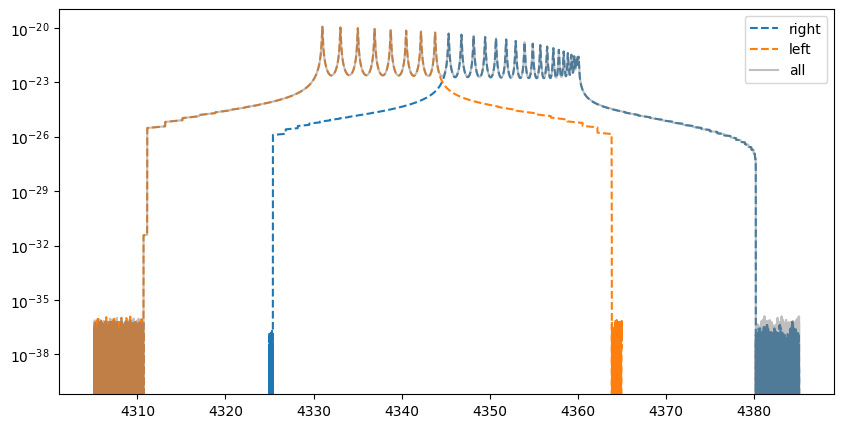

In [7]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

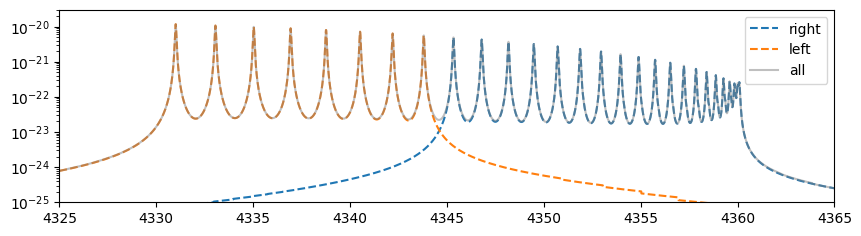

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
plt.show()

After performing the stitching, it is confirmed that the computed results closely match those obtained in the original wavenumber domain.

In [9]:
filter_length_oneside = opa_open_right.filter_length_oneside
xsv_open_stitch = xsv_open_left[filter_length_oneside:3*filter_length_oneside]+xsv_open_right[0:2*filter_length_oneside]

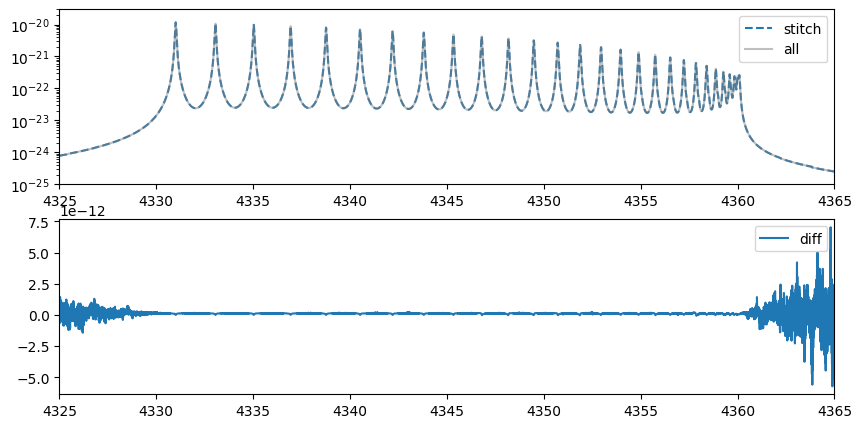

In [11]:



import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(opa_open_all.nu_grid, xsv_open_stitch, color="C0", ls="dashed", label="stitch")
plt.plot(opa_open_all.nu_grid, xsv_open_all[filter_length_oneside:3*filter_length_oneside],alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
ax = fig.add_subplot(212)
plt.plot(nu_grid, xsv_open_all[filter_length_oneside:3*filter_length_oneside]/xsv_open_stitch -1.0, color="C0", label="diff")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.legend()
plt.show()

When `nstitch > 1` is specified in `OpaPremodit`, stitching is performed using OLA as described above.
That's it.